In [5]:
import io
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14

In [7]:
from pathlib import Path
import pandas as pd
import numpy as np

# ✅ UPDATED PATH TO YOUR WINDOWS DIRECTORY
DATA_PATH = Path(r"C:\BFSI\card_fraud.csv")

df = pd.read_csv(DATA_PATH)

df["Transaction_Timestamp"] = pd.to_datetime(df.get("Transaction_Date"), errors="coerce")
df["Transaction_Date"] = df["Transaction_Timestamp"].dt.date

if "Transaction_Time" in df.columns:
    df["Transaction_Time_Parsed"] = pd.to_timedelta(df["Transaction_Time"], errors="coerce")
    df["Transaction_Time_Minute"] = df["Transaction_Time_Parsed"].dt.total_seconds() / 60.0
else:
    df["Transaction_Time_Minute"] = np.nan

df["Transaction_Time_Minute"] = df["Transaction_Time_Minute"].fillna(0)
df["Transaction_Hour"] = df["Transaction_Timestamp"].dt.hour
df["Transaction_Minute"] = df["Transaction_Timestamp"].dt.minute
df["Transaction_Day"] = df["Transaction_Timestamp"].dt.day
df["Transaction_Month"] = df["Transaction_Timestamp"].dt.month
df["Day_of_Week"] = df["Transaction_Timestamp"].dt.day_name()

if "Transaction_Time_Parsed" in df.columns:
    df.drop(columns=["Transaction_Time_Parsed"], inplace=True)

numeric_candidates = [
    "Transaction_Amount",
    "Previous_Transaction_Count",
    "Distance_Between_Transactions_km",
    "Time_Since_Last_Transaction_min",
    "Transaction_Velocity",
    "Transaction_Time_Minute",
    "Transaction_Hour",
    "Transaction_Minute",
    "Transaction_Day",
    "Transaction_Month",
]

for column in numeric_candidates:
    if column in df.columns:
        df[column] = pd.to_numeric(df[column], errors="coerce")

if "isFraud" in df.columns:
    df["isFraud"] = (
        pd.to_numeric(df["isFraud"], errors="coerce")
        .fillna(0)
        .round()
        .clip(lower=0)
        .astype(int)
    )

numeric_only_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_only_columns = [col for col in numeric_only_columns if df[col].nunique(dropna=False) > 1]

id_like_columns = {"Transaction_ID", "User_ID", "Merchant_ID", "Device_ID"}
metric_columns = [col for col in numeric_only_columns if col not in id_like_columns and col != "isFraud"]

plot_sample = df if len(df) <= 10000 else df.sample(10000, random_state=42)
plot_sample = plot_sample.copy()

if metric_columns:
    plot_sample[metric_columns] = plot_sample[metric_columns].astype(float)

key_metrics = [
    col for col in [
        "Transaction_Amount",
        "Distance_Between_Transactions_km",
        "Time_Since_Last_Transaction_min",
        "Transaction_Velocity",
        "Transaction_Time_Minute",
    ]
    if col in df.columns
]

print(f"Loaded dataset with {df.shape[0]:,} rows and {df.shape[1]} columns.")
print(f"Using sample of {len(plot_sample):,} rows for heavy visualisations.")


Loaded dataset with 100,000 rows and 25 columns.
Using sample of 10,000 rows for heavy visualisations.


In [8]:
display(df.head())
display(df.sample(n=min(5, len(df)), random_state=42))

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Date,Transaction_Time,Transaction_Location,Merchant_ID,Device_ID,Card_Type,Transaction_Currency,...,Transaction_Velocity,Transaction_Category,isFraud,Transaction_Timestamp,Transaction_Time_Minute,Transaction_Hour,Transaction_Minute,Transaction_Day,Transaction_Month,Day_of_Week
0,1001,68389745,69635000,2024-01-01,0:00:00,Surkhandarya,6710,2060,UzCard,UZS,...,5,Transfer,1,2024-01-01 00:00:00,0.0,0,0,1,1,Monday
1,1002,42122340,53486000,2024-01-01,0:01:00,Namangan,6498,2797,UzCard,USD,...,9,Cash Out,1,2024-01-01 00:01:00,1.0,0,1,1,1,Monday
2,1003,87539955,24262000,2024-01-01,0:02:00,Navoiy,5039,2519,Humo,UZS,...,7,Cash In,1,2024-01-01 00:02:00,2.0,0,2,1,1,Monday
3,1004,98657863,56019000,2024-01-01,0:03:00,Bukhara,6115,2641,Humo,UZS,...,1,Payment,1,2024-01-01 00:03:00,3.0,0,3,1,1,Monday
4,1005,88084360,87823000,2024-01-01,0:04:00,Andijan,5072,2923,Humo,UZS,...,8,Cash Out,1,2024-01-01 00:04:00,4.0,0,4,1,1,Monday


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Date,Transaction_Time,Transaction_Location,Merchant_ID,Device_ID,Card_Type,Transaction_Currency,...,Transaction_Velocity,Transaction_Category,isFraud,Transaction_Timestamp,Transaction_Time_Minute,Transaction_Hour,Transaction_Minute,Transaction_Day,Transaction_Month,Day_of_Week
75721,76722,18312161,3712000,2024-02-22,14:01:00,Namangan,6962,2377,UzCard,USD,...,9,Transfer,0,2024-02-22 14:01:00,841.0,14,1,22,2,Thursday
80184,81185,75374643,88147000,2024-02-25,16:24:00,Bukhara,6547,2965,Humo,USD,...,8,Cash In,0,2024-02-25 16:24:00,984.0,16,24,25,2,Sunday
19864,20865,41709653,45548000,2024-01-14,19:04:00,Sirdarya,5144,2420,UzCard,USD,...,9,Cash Out,1,2024-01-14 19:04:00,1144.0,19,4,14,1,Sunday
76699,77700,18122643,91114000,2024-02-23,6:19:00,Navoiy,5668,2161,UzCard,USD,...,3,Transfer,0,2024-02-23 06:19:00,379.0,6,19,23,2,Friday
92991,93992,98608658,91841000,2024-03-05,13:51:00,Surkhandarya,6364,2077,Humo,UZS,...,3,Cash In,0,2024-03-05 13:51:00,831.0,13,51,5,3,Tuesday


In [9]:
buffer = io.StringIO()
df.info(buf=buffer)
print(buffer.getvalue())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Transaction_ID                    100000 non-null  int64         
 1   User_ID                           100000 non-null  int64         
 2   Transaction_Amount                100000 non-null  int64         
 3   Transaction_Date                  100000 non-null  object        
 4   Transaction_Time                  100000 non-null  object        
 5   Transaction_Location              100000 non-null  object        
 6   Merchant_ID                       100000 non-null  int64         
 7   Device_ID                         100000 non-null  int64         
 8   Card_Type                         100000 non-null  object        
 9   Transaction_Currency              100000 non-null  object        
 10  Transaction_Status               

In [10]:
numeric_summary = df.select_dtypes(include=[np.number]).describe().transpose()
categorical_summary = df.select_dtypes(include=["object", "category"]).describe().transpose()

display(numeric_summary)
display(categorical_summary)

,count,mean,std,min,25%,50%,75%,max
Transaction_ID,100000.0,5.100050e+04,2.886766e+04,1001.00,2.600075e+04,51000.50,7.600025e+04,1.010000e+05
User_ID,100000.0,5.494949e+07,2.600718e+07,10000555.00,3.241005e+07,54864944.50,7.754587e+07,9.999900e+07
Transaction_Amount,100000.0,4.994914e+07,2.882889e+07,11000.00,2.511300e+07,49799000.00,7.503175e+07,1.000000e+08
Merchant_ID,100000.0,5.999334e+03,5.770638e+02,5001.00,5.500000e+03,6000.00,6.499000e+03,7.000000e+03
Device_ID,100000.0,2.500864e+03,2.889645e+02,2001.00,2.250000e+03,2501.00,2.751000e+03,3.000000e+03
Previous_Transaction_Count,100000.0,2.499505e+01,1.411035e+01,1.00,1.300000e+01,25.00,3.700000e+01,4.900000e+01
Distance_Between_Transactions_km,100000.0,2.494473e+03,1.447158e+03,0.01,1.235233e+03,2497.55,3.746573e+03,4.999980e+03
Time_Since_Last_Transaction_min,100000.0,7.199541e+02,4.144348e+02,1.00,3.620000e+02,720.00,1.078000e+03,1.439000e+03
Transaction_Velocity,100000.0,5.007310e+00,2.579051e+00,1.00,3.000000e+00,5.00,7.000000e+00,9.000000e+00
isFraud,100000.0,5.000000e-01,5.000025e-01,0.00,0.000000e+00,0.50,1.000000e+00,1.000000e+00


,count,unique,top,freq
Transaction_Date,100000,70,2024-01-01,1440
Transaction_Time,100000,1440,10:39:00,70
Transaction_Location,100000,12,Kashkadarya,8511
Card_Type,100000,2,Humo,50024
Transaction_Currency,100000,2,USD,50226
Transaction_Status,100000,3,Failed,33403
Authentication_Method,100000,3,2FA,33512
Transaction_Category,100000,4,Cash Out,25091
Day_of_Week,100000,7,Monday,14400


In [11]:
missing_report = (
    df.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda frame: (frame["missing_count"] / len(df) * 100).round(2))
    .sort_values("missing_count", ascending=False)
)

display(missing_report)
duplicate_rows = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows:,}")

,missing_count,missing_pct
Transaction_ID,0,0.0
User_ID,0,0.0
Transaction_Amount,0,0.0
Transaction_Date,0,0.0
Transaction_Time,0,0.0
Transaction_Location,0,0.0
Merchant_ID,0,0.0
Device_ID,0,0.0
Card_Type,0,0.0
Transaction_Currency,0,0.0


Duplicate rows: 0


,count,percentage
isFraud,,
0,50000,50.0
1,50000,50.0


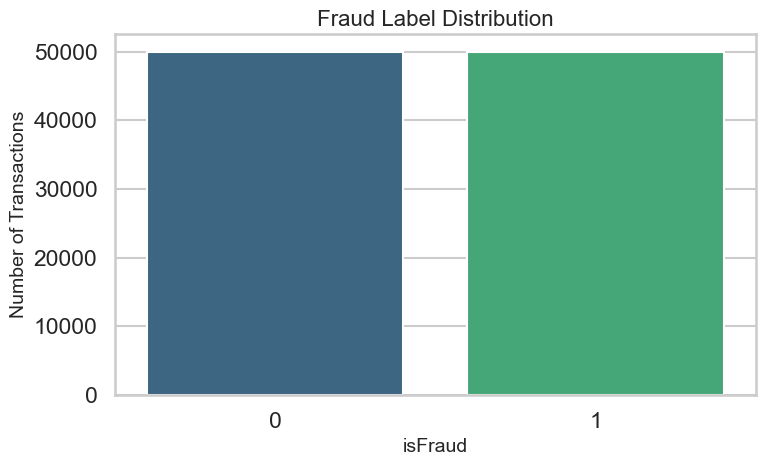

In [12]:
if "isFraud" in df.columns:
    class_counts = (
        df["isFraud"]
        .value_counts(dropna=False)
        .sort_index()
        .rename_axis("isFraud")
        .to_frame("count")
    )
    class_counts["percentage"] = (class_counts["count"] / len(df) * 100).round(2)
    display(class_counts)

    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x="isFraud", palette="viridis")
    plt.title("Fraud Label Distribution")
    plt.xlabel("isFraud")
    plt.ylabel("Number of Transactions")
    plt.tight_layout()
    plt.show()
else:
    print("Column `isFraud` not found; skipping class distribution visualisation.")

,count
Transaction_Status,
Failed,33403
Successful,33321
Reversed,33276


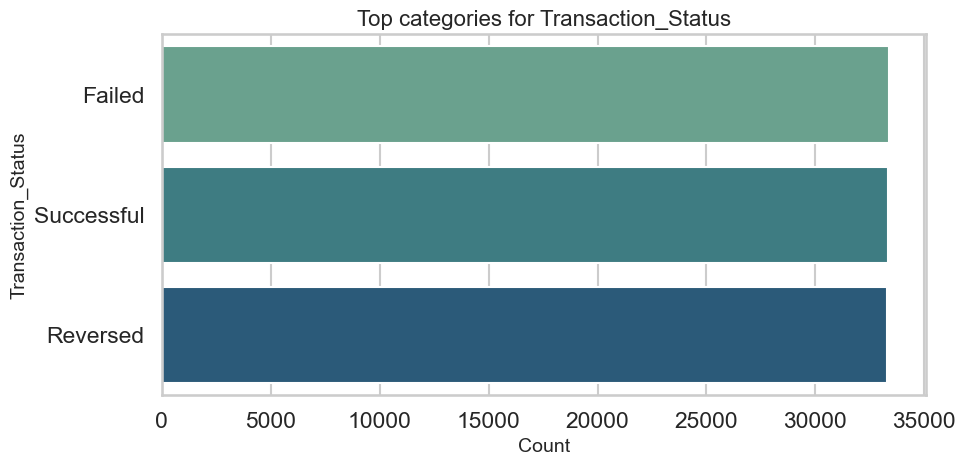

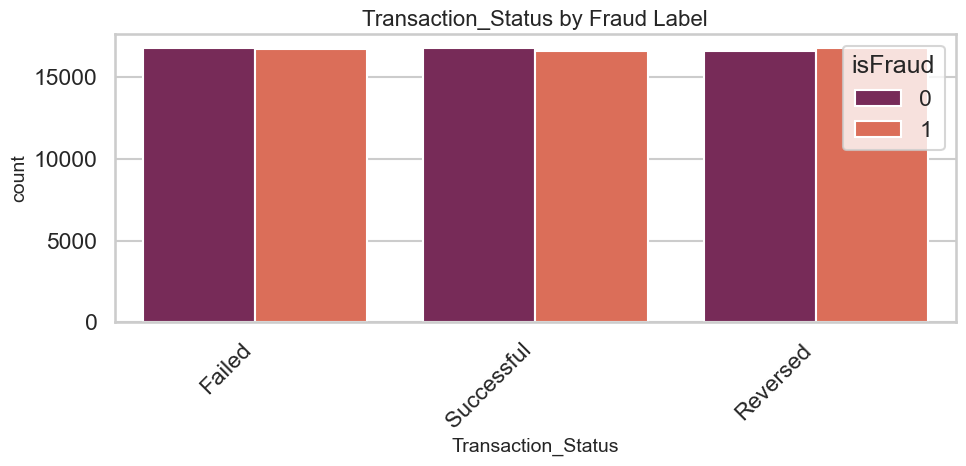

,count
Card_Type,
Humo,50024
UzCard,49976


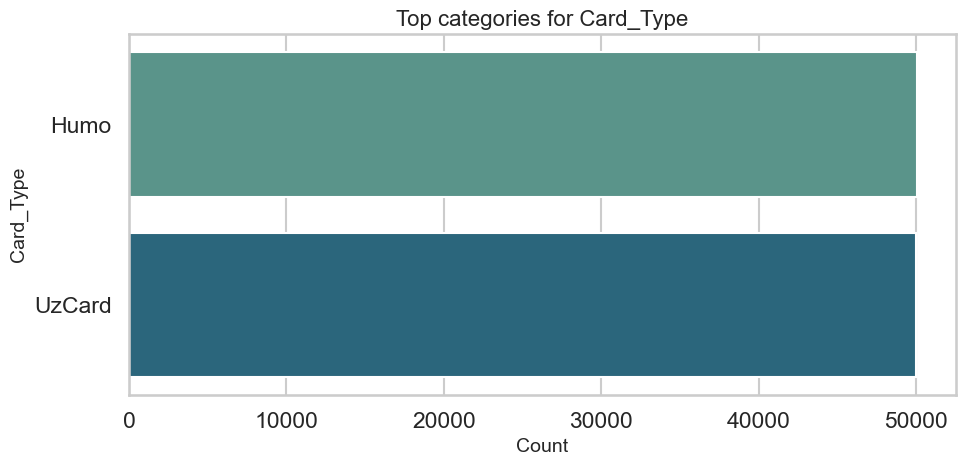

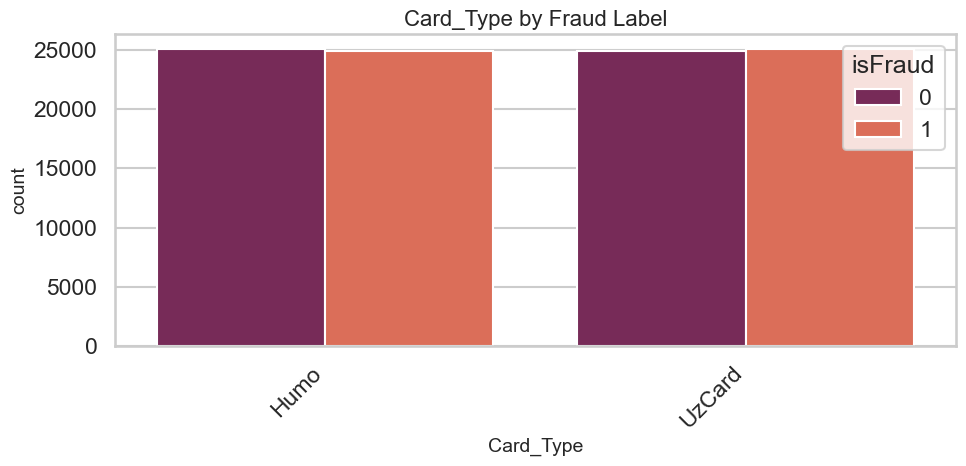

,count
Transaction_Currency,
USD,50226
UZS,49774


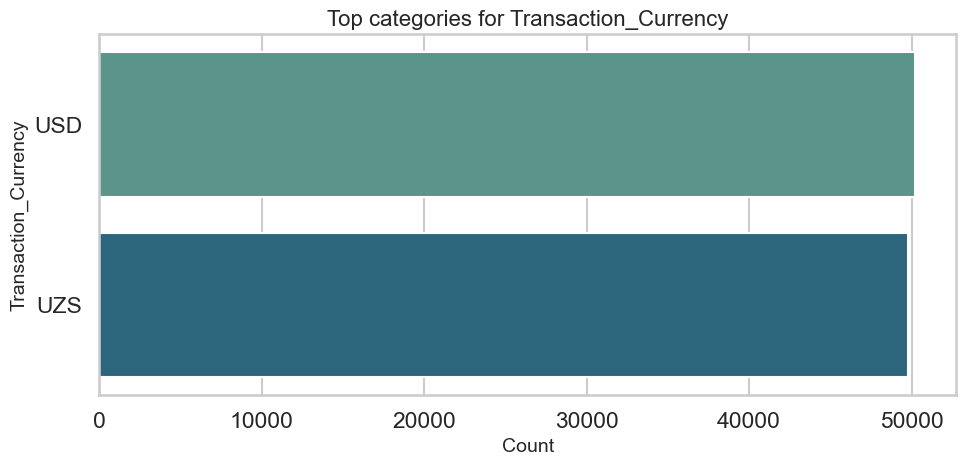

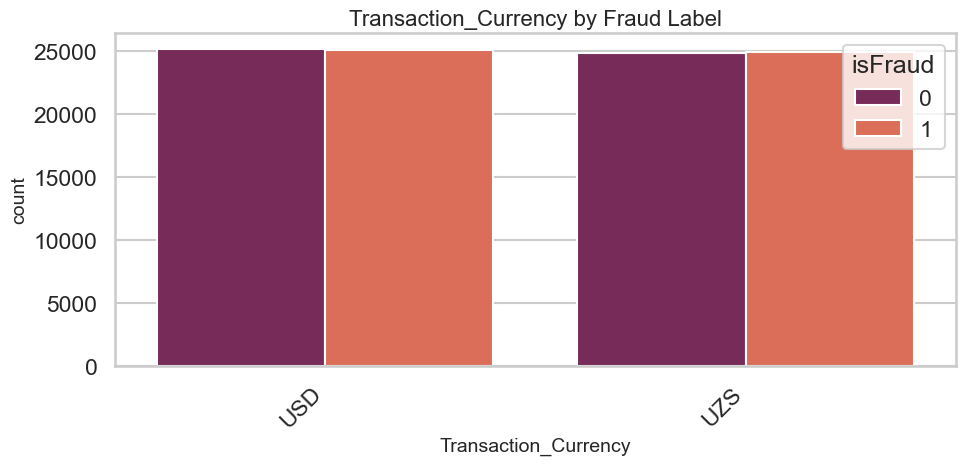

,count
Transaction_Category,
Cash Out,25091
Cash In,25013
Transfer,24952
Payment,24944


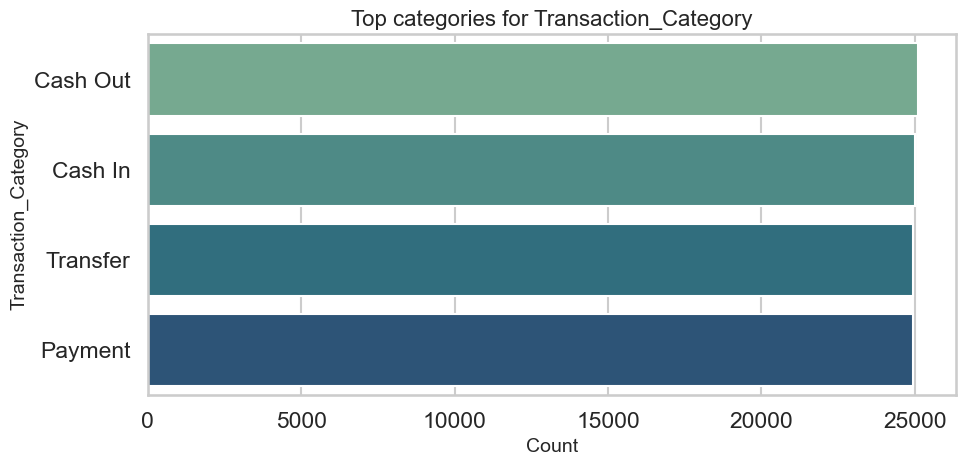

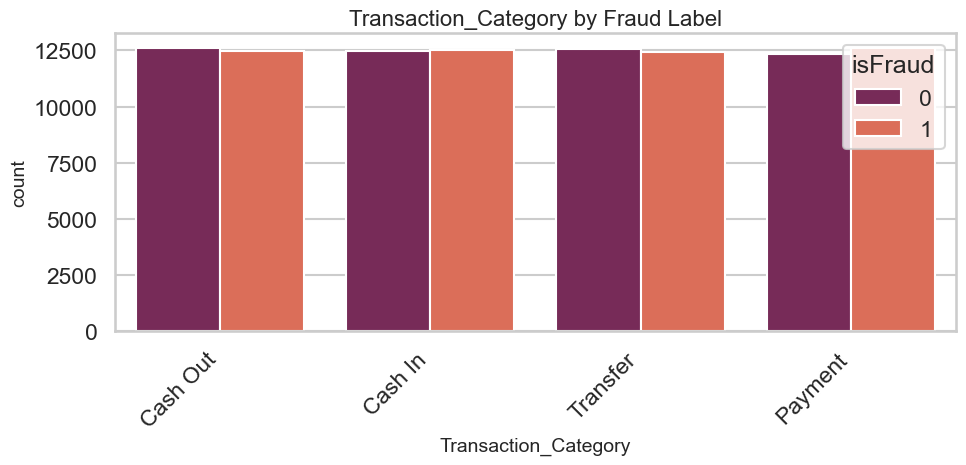

,count
Authentication_Method,
2FA,33512
Biometric,33386
Password,33102


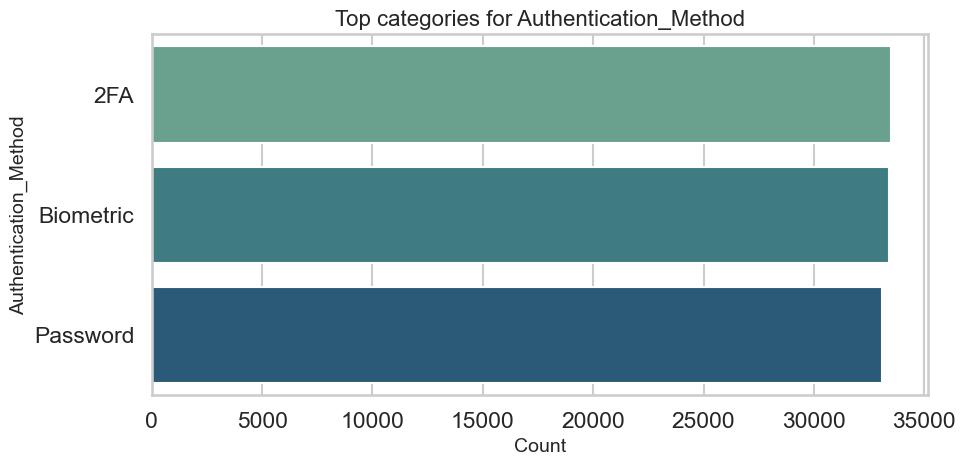

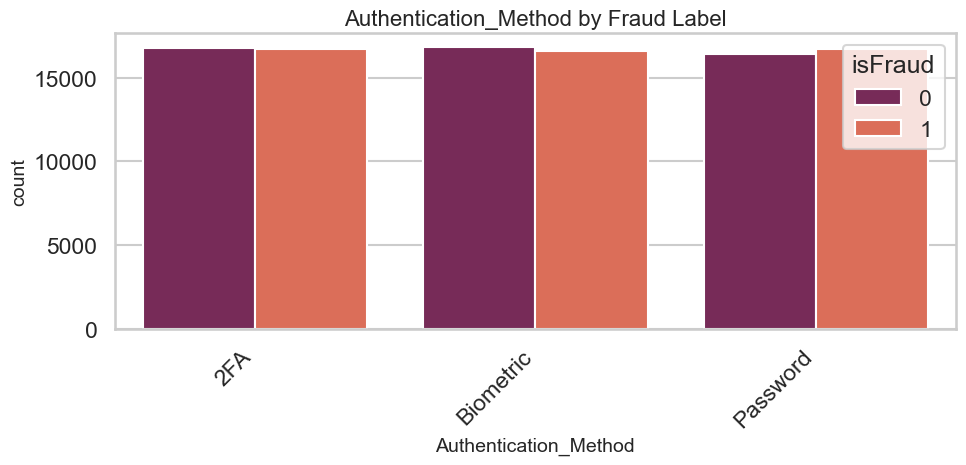

,count
Transaction_Location,
Kashkadarya,8511
Bukhara,8397
Andijan,8397
Samarkand,8378
Namangan,8357
Navoiy,8355
Tashkent,8335
Surkhandarya,8324
Khorezm,8273


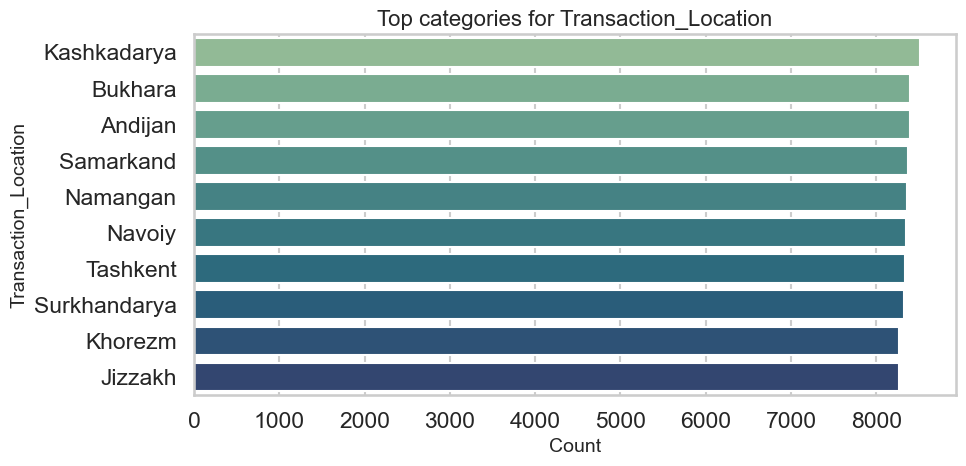

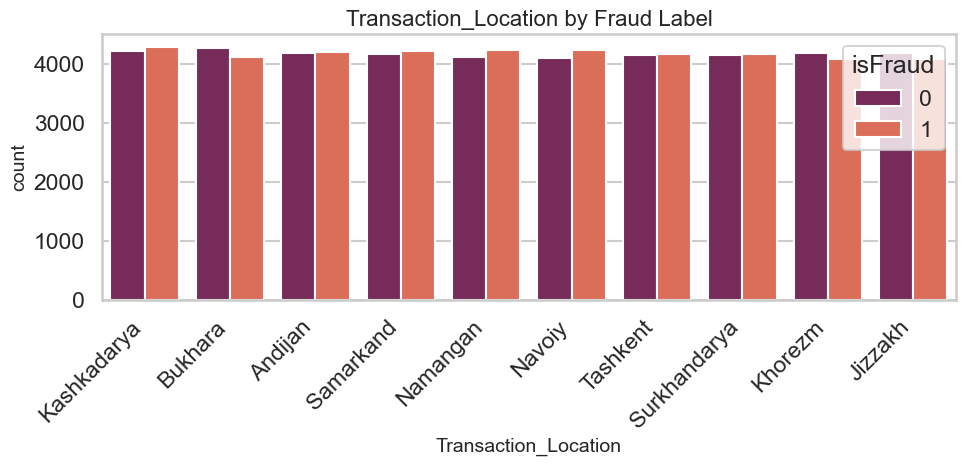

,count
Day_of_Week,
Monday,14400
Tuesday,14400
Wednesday,14400
Thursday,14400
Friday,14400
Saturday,14400
Sunday,13600


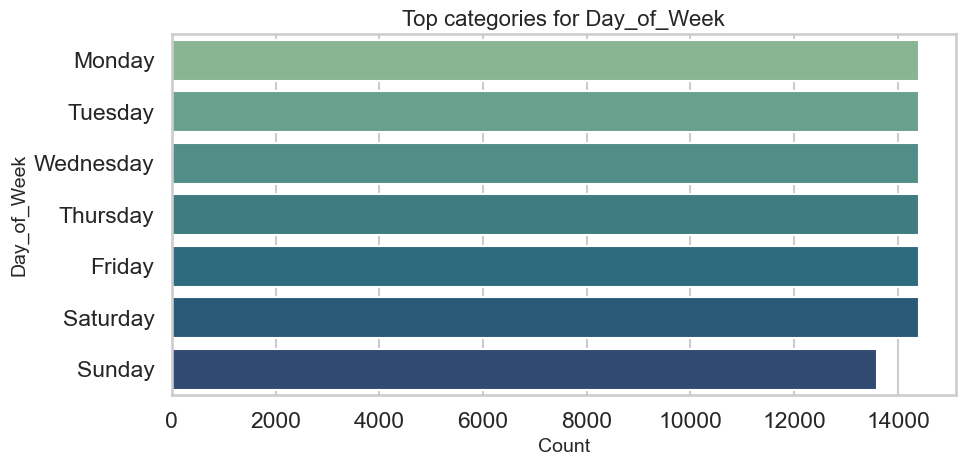

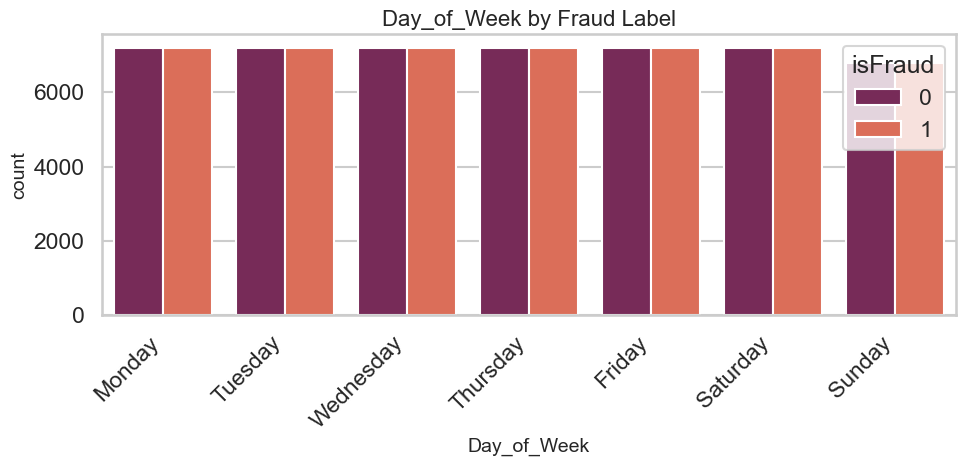

In [14]:
categorical_focus = [
    "Transaction_Status",
    "Card_Type",
    "Transaction_Currency",
    "Transaction_Category",
    "Authentication_Method",
    "Transaction_Location",
    "Day_of_Week",
]

for column in categorical_focus:
    if column in df.columns:
        top_counts = df[column].value_counts(dropna=False).head(10)
        display(top_counts.to_frame(name="count"))

        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, y=column, order=top_counts.index, palette="crest")
        plt.title(f"Top categories for {column}")
        plt.xlabel("Count")
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()

        if "isFraud" in df.columns and df[column].nunique(dropna=False) <= 12:
            plt.figure(figsize=(10, 5))
            sns.countplot(data=df, x=column, hue="isFraud", order=top_counts.index, palette="rocket")
            plt.title(f"{column} by Fraud Label")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

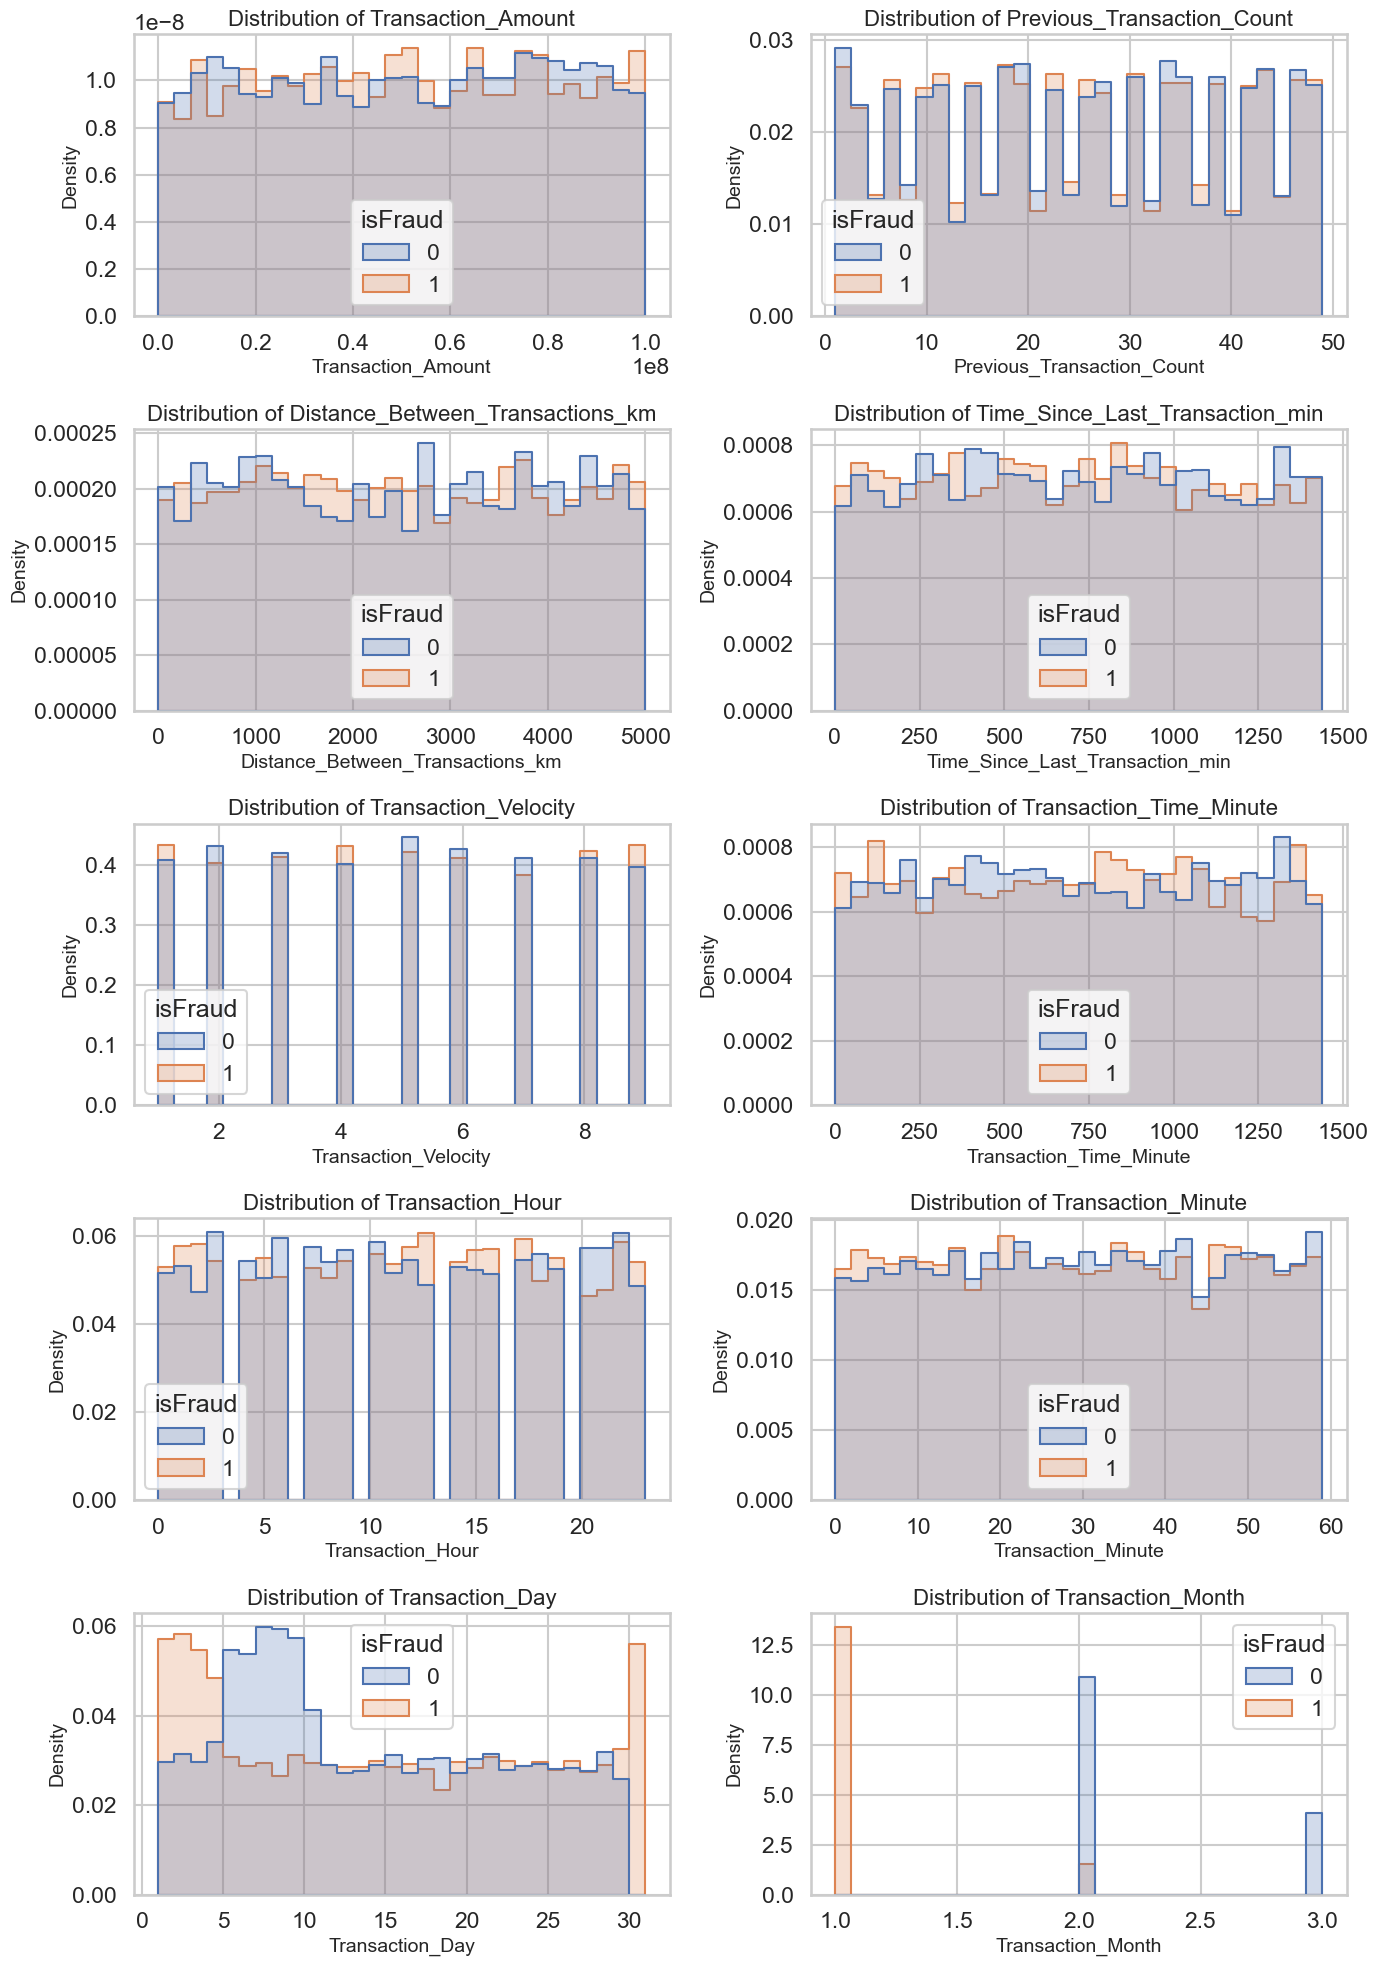

In [15]:
if metric_columns:
    n_cols = 2
    n_rows = math.ceil(len(metric_columns) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, column in zip(axes, metric_columns):
        sns.histplot(
            data=plot_sample,
            x=column,
            hue="isFraud" if "isFraud" in plot_sample.columns else None,
            bins=30,
            kde=False,
            ax=ax,
            element="step",
            stat="density",
            common_norm=False,
            discrete=False,
        )
        ax.set_title(f"Distribution of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Density")

    for ax in axes[len(metric_columns):]:
        ax.remove()

    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns available for distribution plots.")

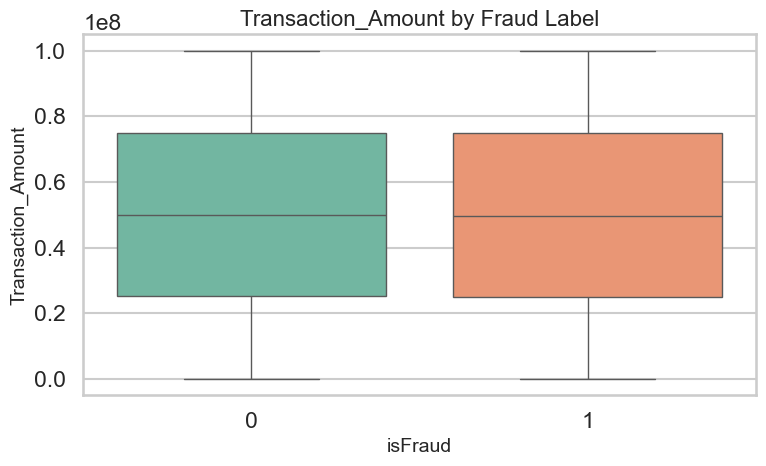

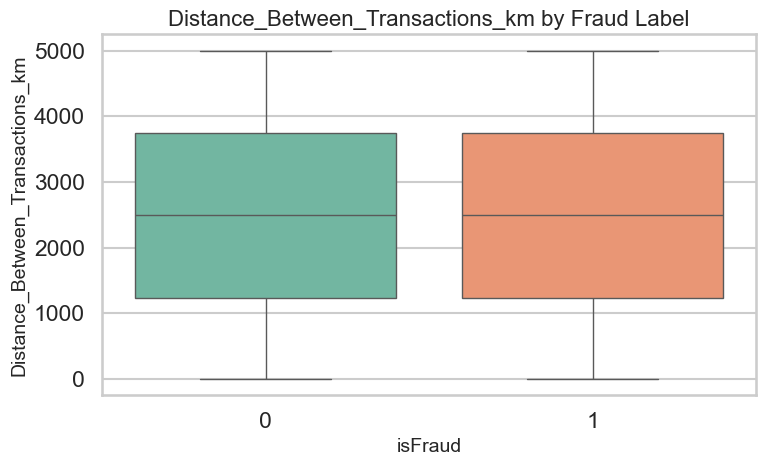

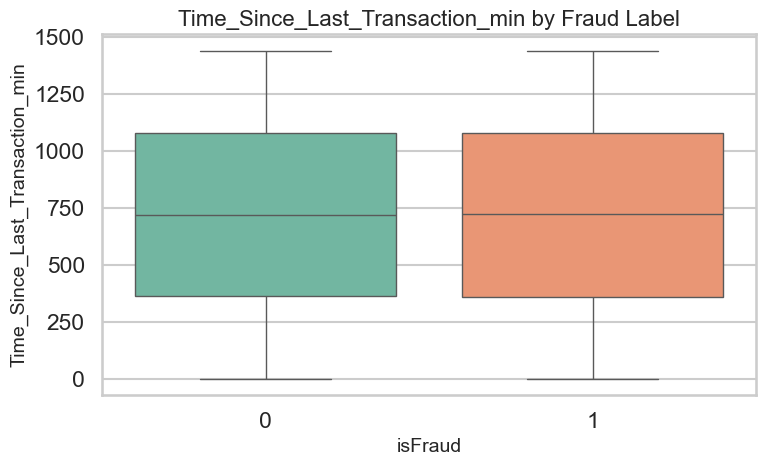

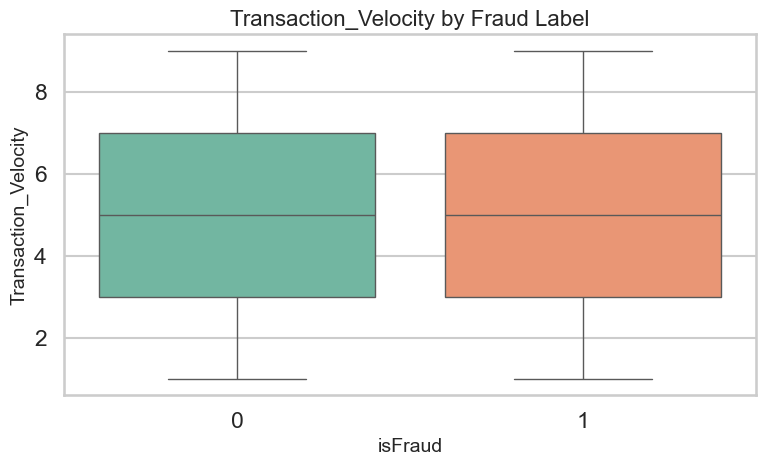

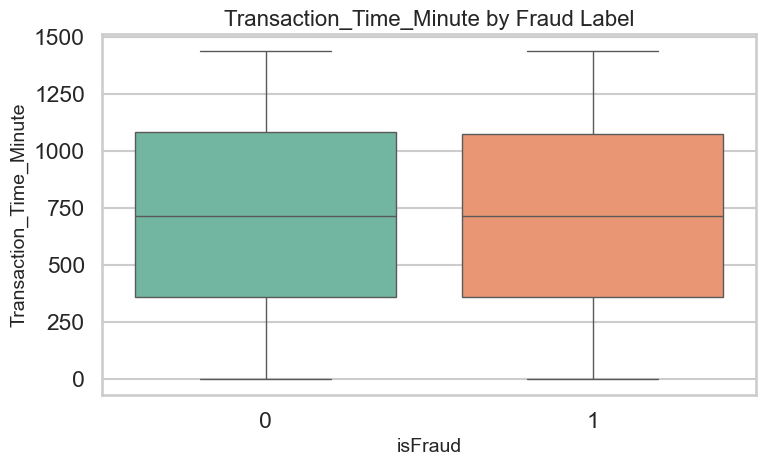

In [16]:
if key_metrics and "isFraud" in df.columns:
    for column in key_metrics:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df, x="isFraud", y=column, palette="Set2")
        plt.title(f"{column} by Fraud Label")
        plt.xlabel("isFraud")
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()
else:
    print("Key metric columns or `isFraud` not available for boxplot comparisons.")

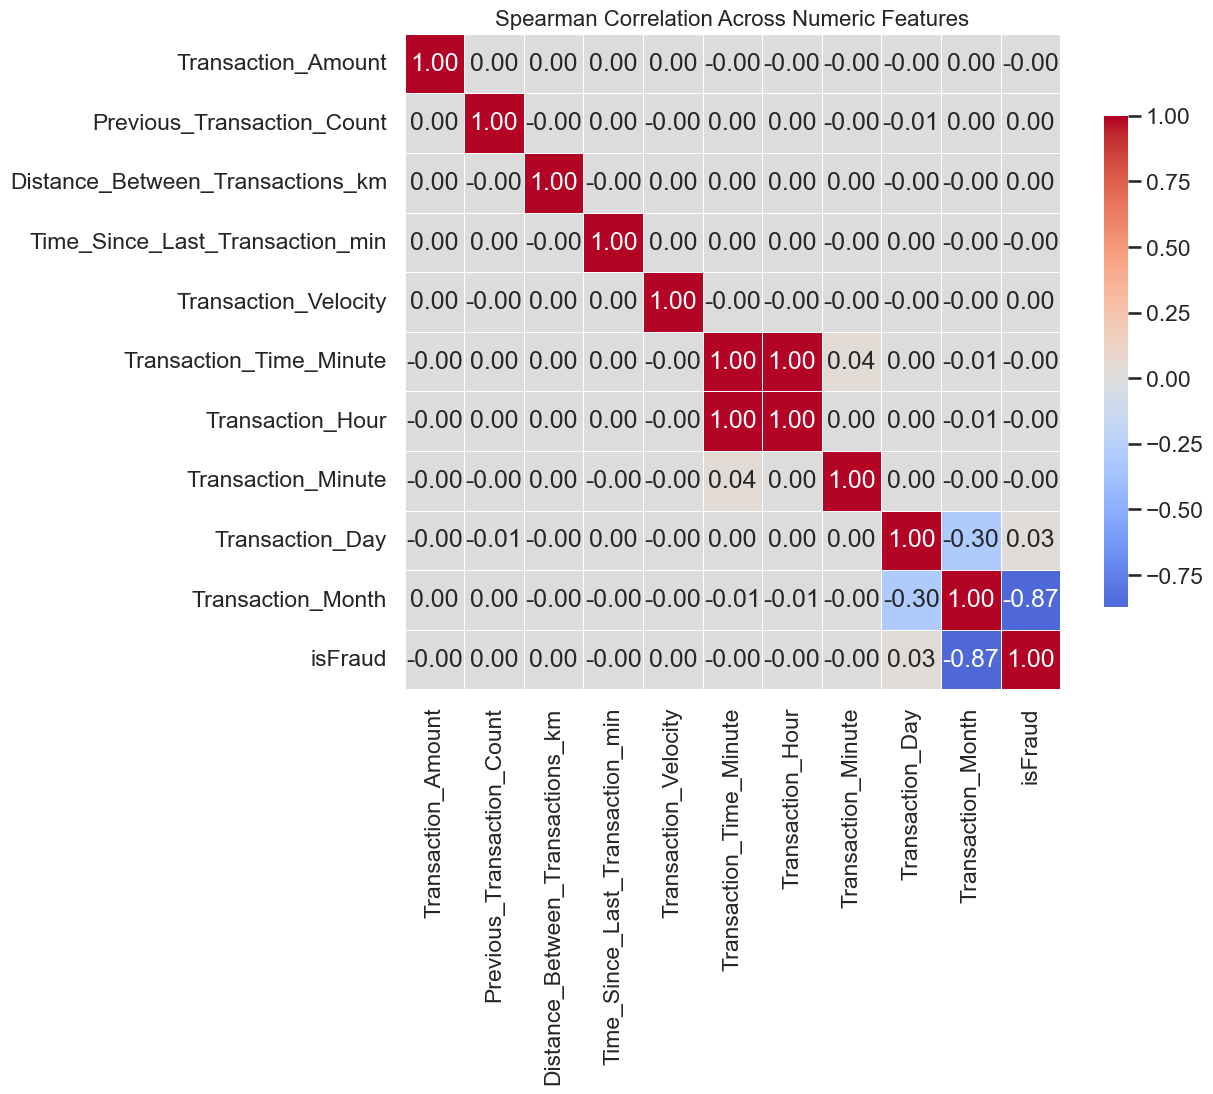

In [17]:
corr_features = [col for col in metric_columns + ["isFraud"] if col in df.columns]

if len(corr_features) >= 2:
    corr_matrix = df[corr_features].corr(method="spearman")
    plt.figure(figsize=(1.2 * len(corr_features), 1.0 * len(corr_features)))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75},
    )
    plt.title("Spearman Correlation Across Numeric Features")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric features to compute correlation heatmap.")

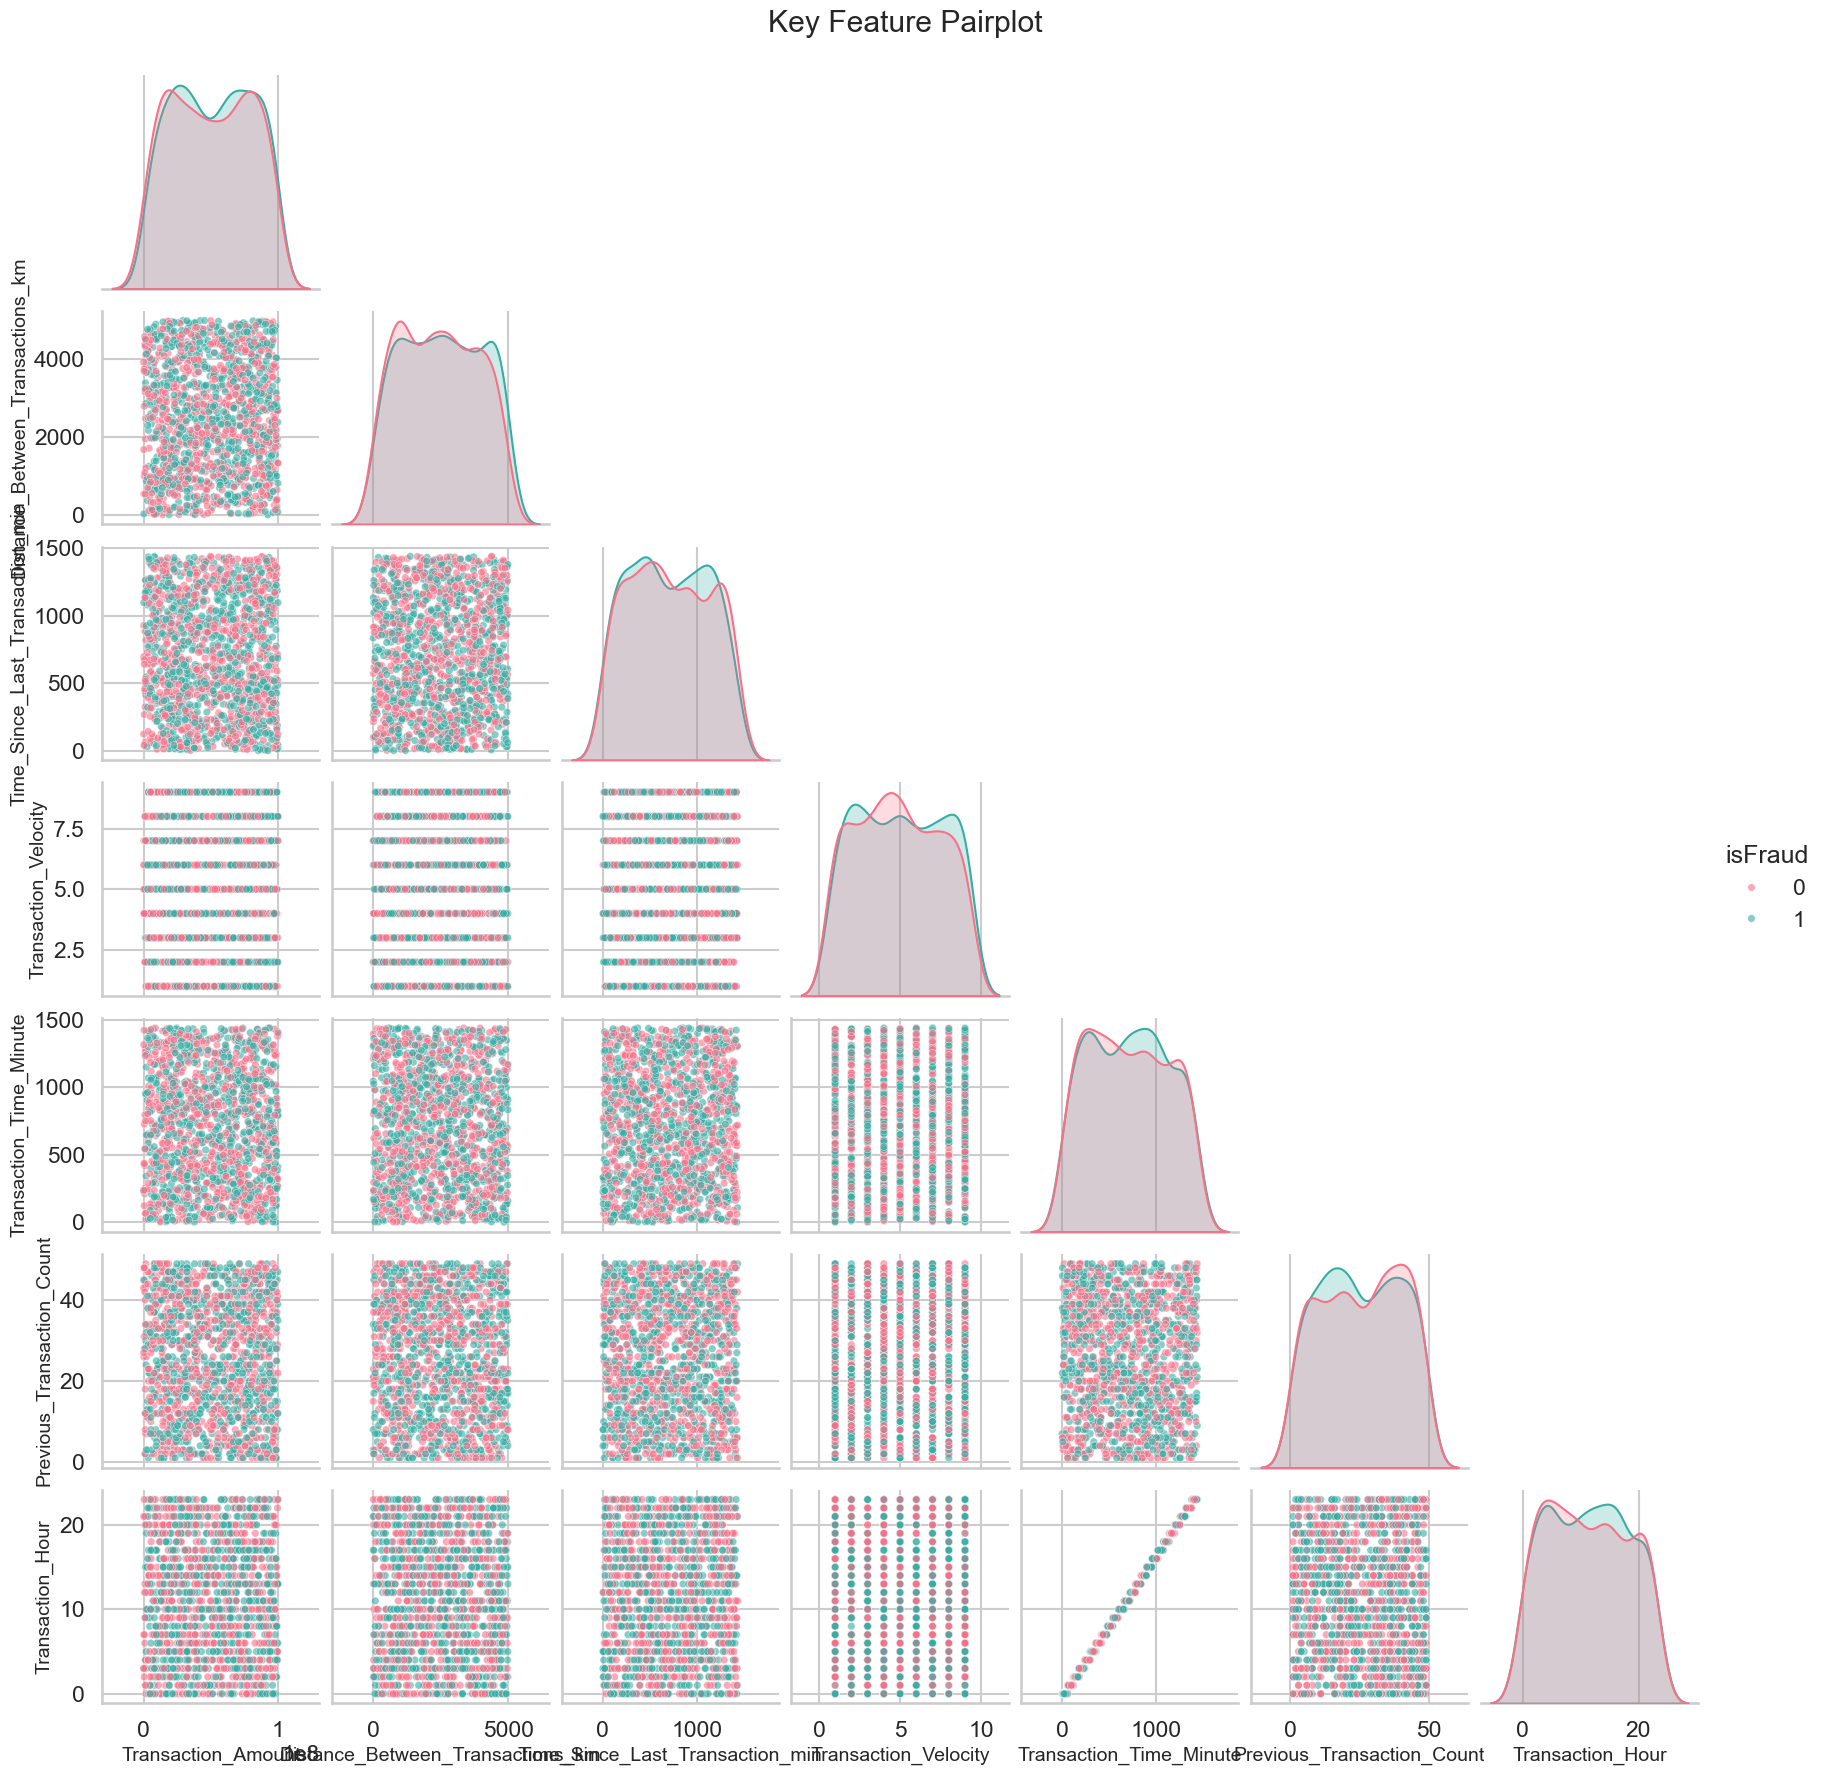

In [18]:
pairplot_features = list(dict.fromkeys(key_metrics + ["Previous_Transaction_Count", "Transaction_Velocity", "Transaction_Hour"]))
pairplot_features = [col for col in pairplot_features if col in plot_sample.columns]

if len(pairplot_features) >= 2:
    pairplot_columns = pairplot_features + (["isFraud"] if "isFraud" in plot_sample.columns else [])
    pairplot_data = plot_sample[pairplot_columns].dropna()
    if len(pairplot_data) > 1500:
        pairplot_data = pairplot_data.sample(1500, random_state=42)
    if len(pairplot_data) >= 2:
        g = sns.pairplot(
            pairplot_data,
            vars=pairplot_features,
            hue="isFraud" if "isFraud" in pairplot_data.columns else None,
            corner=True,
            diag_kind="kde",
            palette="husl",
            plot_kws={"alpha": 0.6, "s": 30},
        )
        g.fig.suptitle("Key Feature Pairplot", y=1.02)
        plt.show()
    else:
        print("Pairplot sample became empty after filtering; skipping plot.")
else:
    print("Not enough features available for pairplot visualisation.")

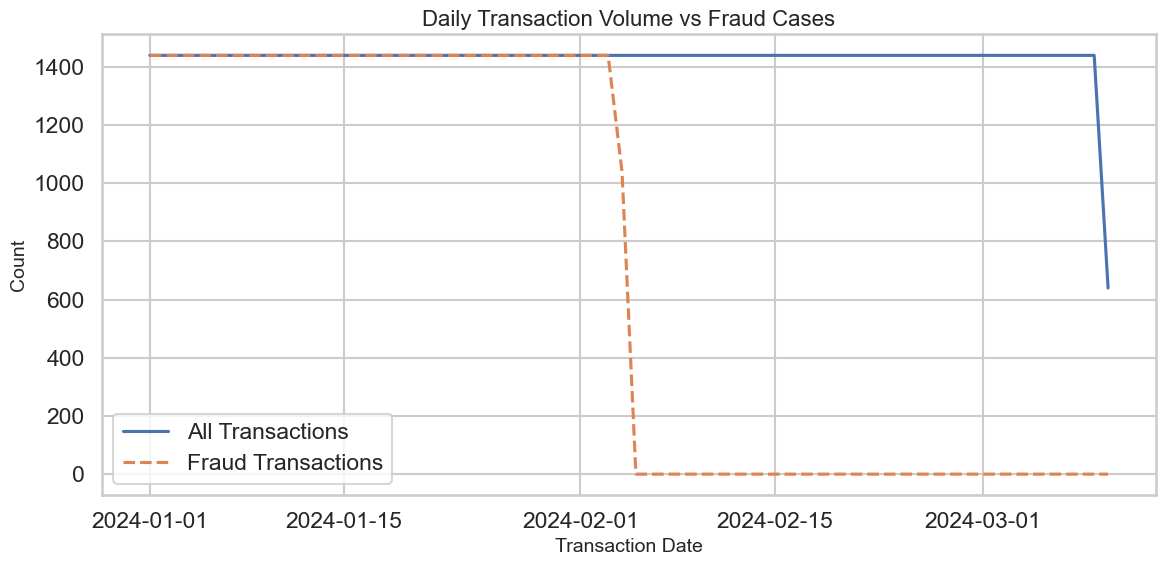

In [19]:
if "Transaction_Date" in df.columns:
    daily_counts = df.groupby("Transaction_Date").size().rename("transactions")
    daily_fraud = (
        df[df.get("isFraud", 0) == 1]
        .groupby("Transaction_Date")
        .size()
        .rename("fraud_transactions")
    )
    timeline = pd.concat([daily_counts, daily_fraud], axis=1).fillna(0)

    plt.figure(figsize=(12, 6))
    plt.plot(timeline.index, timeline["transactions"], label="All Transactions")
    if "fraud_transactions" in timeline.columns:
        plt.plot(timeline.index, timeline["fraud_transactions"], label="Fraud Transactions", linestyle="--")
    plt.title("Daily Transaction Volume vs Fraud Cases")
    plt.xlabel("Transaction Date")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Column `Transaction_Date` not found; skipping timeline plot.")

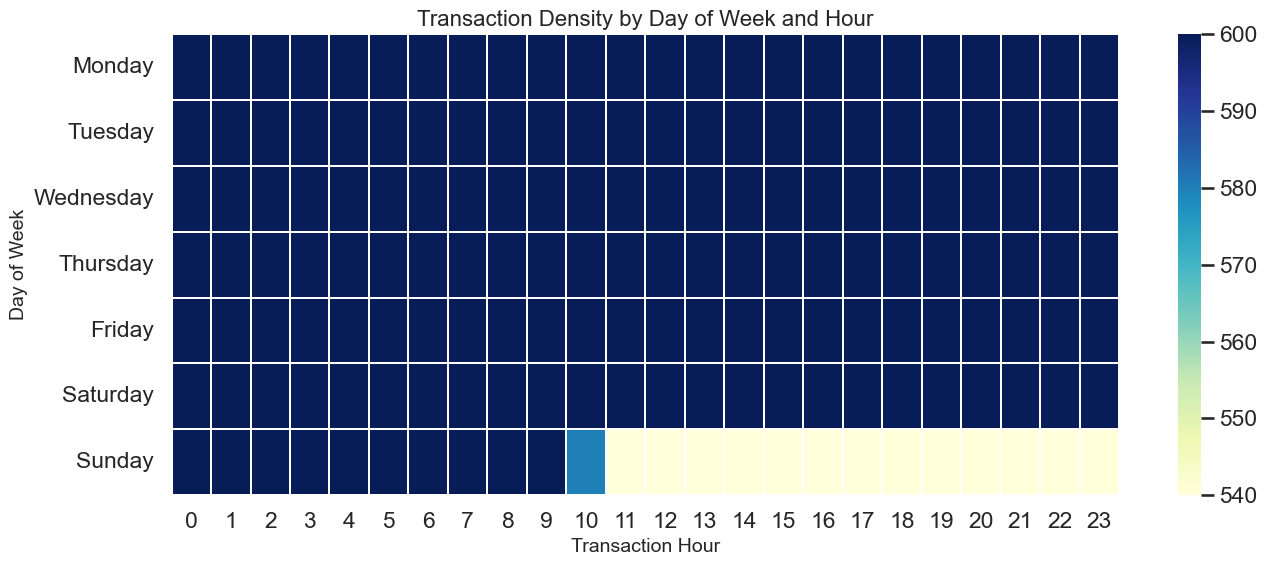

In [20]:
if {"Day_of_Week", "Transaction_Hour"}.issubset(df.columns):
    day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    pivot_table = (
        df.pivot_table(
            index="Day_of_Week",
            columns="Transaction_Hour",
            values="Transaction_ID",
            aggfunc="count",
        )
        .fillna(0)
    )
    pivot_table = pivot_table.reindex(day_order)

    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=0.3)
    plt.title("Transaction Density by Day of Week and Hour")
    plt.xlabel("Transaction Hour")
    plt.ylabel("Day of Week")
    plt.tight_layout()
    plt.show()
else:
    print("Required columns for day/hour heatmap not available.")